# Using TensorFlow on Multiple GPUs #

TensorFlow is a popular open source platform for machine learning that enables parallelism across GPU cores. This parallelism ends up amounting to considerably 
reduced computation times, as performance is scaled with data size, unlike CPU-based operations, which do not scale with the data at a constant rate (for an
in-depth look, check out the [Introduction to Tensorflow Quickbyte](https://github.com/UNM-CARC/QuickBytes/blob/master/Tensorflow_documentation.md)).

## Overview of Conda Environments ##

In order to get started, you must first install the GPU-enabled version of TensorFlow. Instructions for setting up and doing that within a conda environment can be
found in the [Install Deep Learning Packages Quickbyte](https://github.com/UNM-CARC/QuickBytes/blob/master/Install%20deep%20learning%20packages.md).

Note that in addition to the GPU-enabled version of TensorFlow, you will also want to install `numpy`, `matpotlib`, and `scikit-learn`. It is
also recommended that you use `conda install ipykernel` so that you can run your code on CARC's JupyterHub interface, like in this tutorial.

## Multiple-GPU Processes ##

On Xena, there are 4 dual GPU nodes available and this tutorial will cover the use of one node with 2 GPUs to run a neural network code. This tutorial will use documentation for how to do single-host, multi-device synchronous training with the Keras library.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

First we will need to define some parameters. We will be using a decaying learning rate with the Adam optimizer, but that is not strictly necessary, so feel free to play around with these and the other parameters like `epochs`, `batch_size` and number of `neurons_per_hidden_layer`. The variables `Nin` and `Nout` will be used to define the number of features and classes in our synthetic dataset, respectively. 

In [2]:
Nin = 10
Nout = 3

init_lr = 1e-3
epochs = 10
batch_size = 32
neurons_per_hidden_layer = 32

opt = optimizers.Adam(lr=init_lr, decay=init_lr/epochs)

We will use the sklearn `make_multilabel_classification` function to generate a synthetic dataset. Also feel free to play around with the number of labels and samples.

In [3]:
xin, yin = make_multilabel_classification(n_samples=100000, n_features=Nin, n_classes=Nout, n_labels=2)

In order to utilize the keras library multi-GPU capabilities, the model must be compiled after allocating multiple GPUs to the problem. Also, the datasets for training, testing, and validation must be cast into tensorflow Datasets. Both of these things can be easily accomplished by first defining two functions---one which creates the model and another which formats the datasets.

In [4]:
def create_model(n_neurons):
    model = models.Sequential()
    model.add(layers.Dense(n_neurons, input_dim=Nin, kernel_initializer='he_uniform', activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(n_neurons, kernel_initializer='he_uniform', activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(Nout, activation='sigmoid'))
    return model

def get_dataset():
    
    x_train, x_test, y_train, y_test = train_test_split(xin, yin)
    
    num_val_samples = 10*y_train.shape[0]//100    # set size of validation dataset to be 10% of training set
    
    # Reserve 'num_val_samples' for use in validation calculation
    x_val = x_train[-num_val_samples:]
    x_train = x_train[:-num_val_samples]
    y_val = y_train[-num_val_samples:]
    y_train = y_train[:-num_val_samples]

    return (
           tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size, drop_remainder=True),
           tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size, drop_remainder=True),
           tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size, drop_remainder=True),
           y_test
           )

Now, in order to utilize multiple GPUs, we must instantiate a MirroredStrategy from the `tf.distribute.MirroredStrategy` API. By default, the strategy will use all GPUs available, but you can configure which specific devices you want to use if you'd like. For here, we will just use the default (which is two).

We will then use the strategy object to open a scope and will create & compile the model inside the distribution scope. 

In [5]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = create_model(neurons_per_hidden_layer)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics='binary_accuracy')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Now we can train the model via `fit()` as usual. In order to test and see if you are using all of the GPUs, you can `ssh` onto the compute node where you are running this tutorial and enter in `nvidia-smi`. You should see that there is a roughly 50/50 split between the two as the training is being performed. You can ignore all of the `INFO:tensorflow` text that gets printed out below.

In [7]:
train_dataset, val_dataset, test_dataset, ytest = get_dataset()
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

<IPython.core.display.Javascript object>


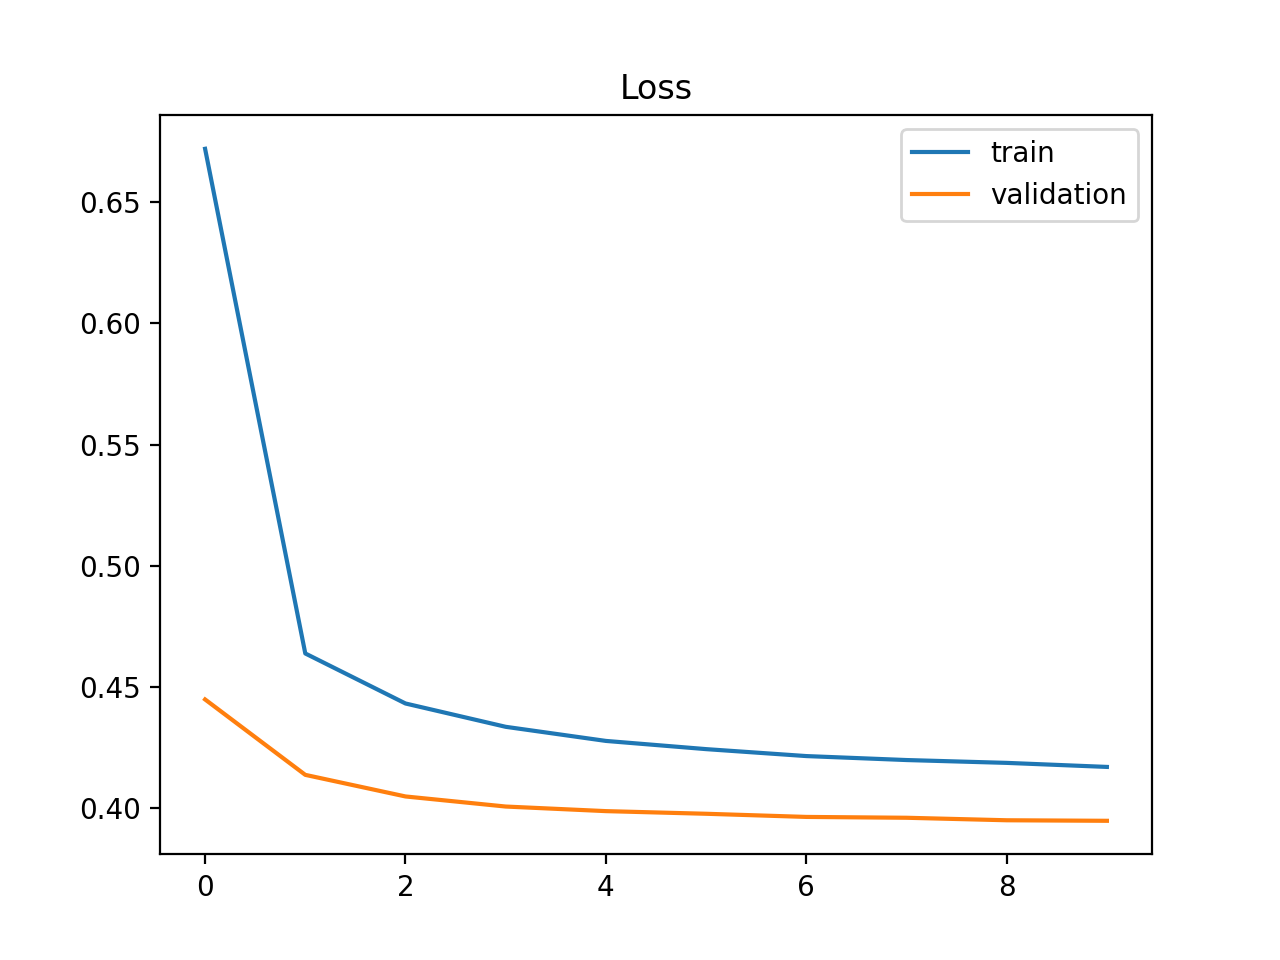

In [8]:
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Finally, you can run some testing diagnostics to see how well your neural network has performed. For this, I optionally allow for `ytest` as an output of my `get_dataset()` functions. This is just a `numpy` array, which I can plot and compare with the `numpy` array that gets produced when I run `model.predict()` on my test dataset. If you would rather just look at the `model.evaluate()` results, this step is unnecessary, but I have included it here for illustrative purposes. As you can see, our neural network does a pretty good job, but probably could be better. Feel free to play around with the parameters and the network architecture to get more desireable results.

In [9]:
score = model.evaluate(test_dataset)
ypred = model.predict(test_dataset)

781/781 [==============================] - 1s 2ms/step - loss: 0.3909 - binary_accuracy: 0.8188


<IPython.core.display.Javascript object>


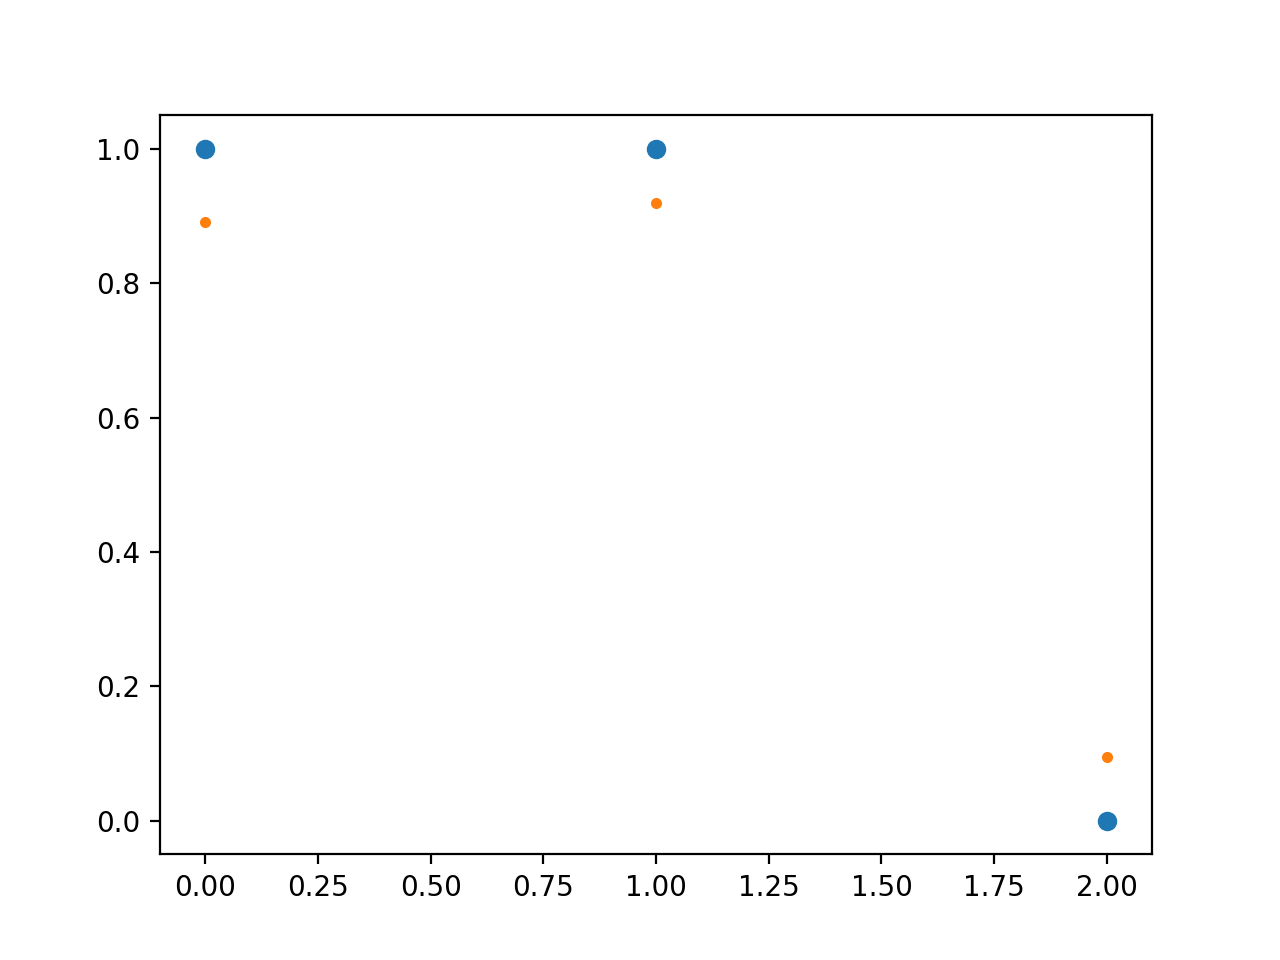

In [10]:
randind = np.random.randint(ytest.shape[0])

plt.figure()
plt.plot(ytest[randind], 'o')
plt.plot(ypred[randind], '.')
plt.ylim([-0.05,1.05])
plt.show()